# Simulation Performance: HMC VS MCMC
    In the following part, I show a comparison between the simulation performances of applying Hamiltonian Monte 
    Carlo and applying Markov Chain Monte Carlo.
    
    The plots show HMC significantly outperforms MCMC in this example.  

In [1]:
from Monte_Carlo_Methods import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix
from functools import partial

def negate_mvn_logpdf(x, mean, cov):
  # return nagative log likelihood of multivariate normal distribution
  # Suppose x is k-dimenional vector
  # x, mean are like (k,1) or (k,)
  # x, mean, cov are np.array

    k = x.shape[0]
    tmp1 = - k / 2.0 * np.log(2 * np.pi)        # scalar
    tmp2 = - 0.5 * np.log(np.linalg.det(cov))
    tmp3 = - 0.5 * np.dot(np.dot((x - mean).T, np.linalg.inv(cov)), x - mean)
    result = tmp1 + tmp2 + tmp3
    
    return - result

def grad_negate_mvn_logpdf(x, mean, cov):
  # return nagative gradient of log likelihood 
  # Suppose x is k-dimenional vector
  # x, mean are like (k,1) or (k,)
  # x, mean, cov are np.array
    
    k = x.shape[0]
    result = np.dot(np.linalg.inv(cov),(x - mean)).reshape(k,1)
    return result

### Randomly generate mean, covariance matrix for a multivariate normal distribution:

In [2]:
dim = 10 #dimension of the multivariate normal distribution
cov = make_spd_matrix(n_dim = dim, random_state = 42) #covariance matrix 
u = np.random.uniform(low = -10, high = 10, size = dim) #mean

### Generate samples for this multivariate normal distribution:

In [3]:
samples_mvn = np.random.multivariate_normal(u, cov, 5000)
df_samples_mvn = pd.DataFrame(samples_mvn, columns = ['dim' + str(i + 1) for i in range(dim)])

### Generate samples for this multivariate normal distribution with Hamiltonian Monte Carlo:

In [4]:
Simulator = MC_Machine()
init_guess = u + np.random.normal(0, 5, dim)
res = Simulator.HMC(U = partial(negate_mvn_logpdf, mean = u.reshape(dim,1), cov = cov),
                    grad_U = partial(grad_negate_mvn_logpdf, mean = u.reshape(dim,1), cov = cov),
                    current_q = init_guess.reshape(dim,1), num_simu = 5000, 
                    L = 50, epsilon = 0.03, burn_in = 0.2)

samples_HMC = res['trajectory']
df_samples_HMC = pd.DataFrame(samples_HMC, columns = ['dim' + str(i + 1) for i in range(dim)])
print('acceptance rate =', "%.4f" % res['accept_rate'])

acceptance rate = 0.9998


### Generate samples for this multivariate normal distribution with Markov Chain Monte Carlo:

In [5]:
res = Simulator.MCMC(partial(negate_mvn_logpdf, mean = u.reshape(dim,1), cov = cov), 
                     current_x = init_guess.reshape(dim,1), num_simu = 5000, scale = 0.3, burn_in = 0.2)
samples_MCMC = res['trajectory']
df_samples_MCMC = pd.DataFrame(samples_MCMC, columns = ['dim' + str(i + 1) for i in range(dim)])
print('acceptance rate =', "%.4f" % res['accept_rate'])

acceptance rate = 0.3602


In [6]:
df_samples_mvn['method'] = 'MVN'
df_samples_HMC['method'] = 'HMC'
df_samples_MCMC['method'] = 'MCMC'
df = pd.concat([df_samples_mvn, df_samples_HMC, df_samples_MCMC])
df.reset_index(drop = True, inplace = True)

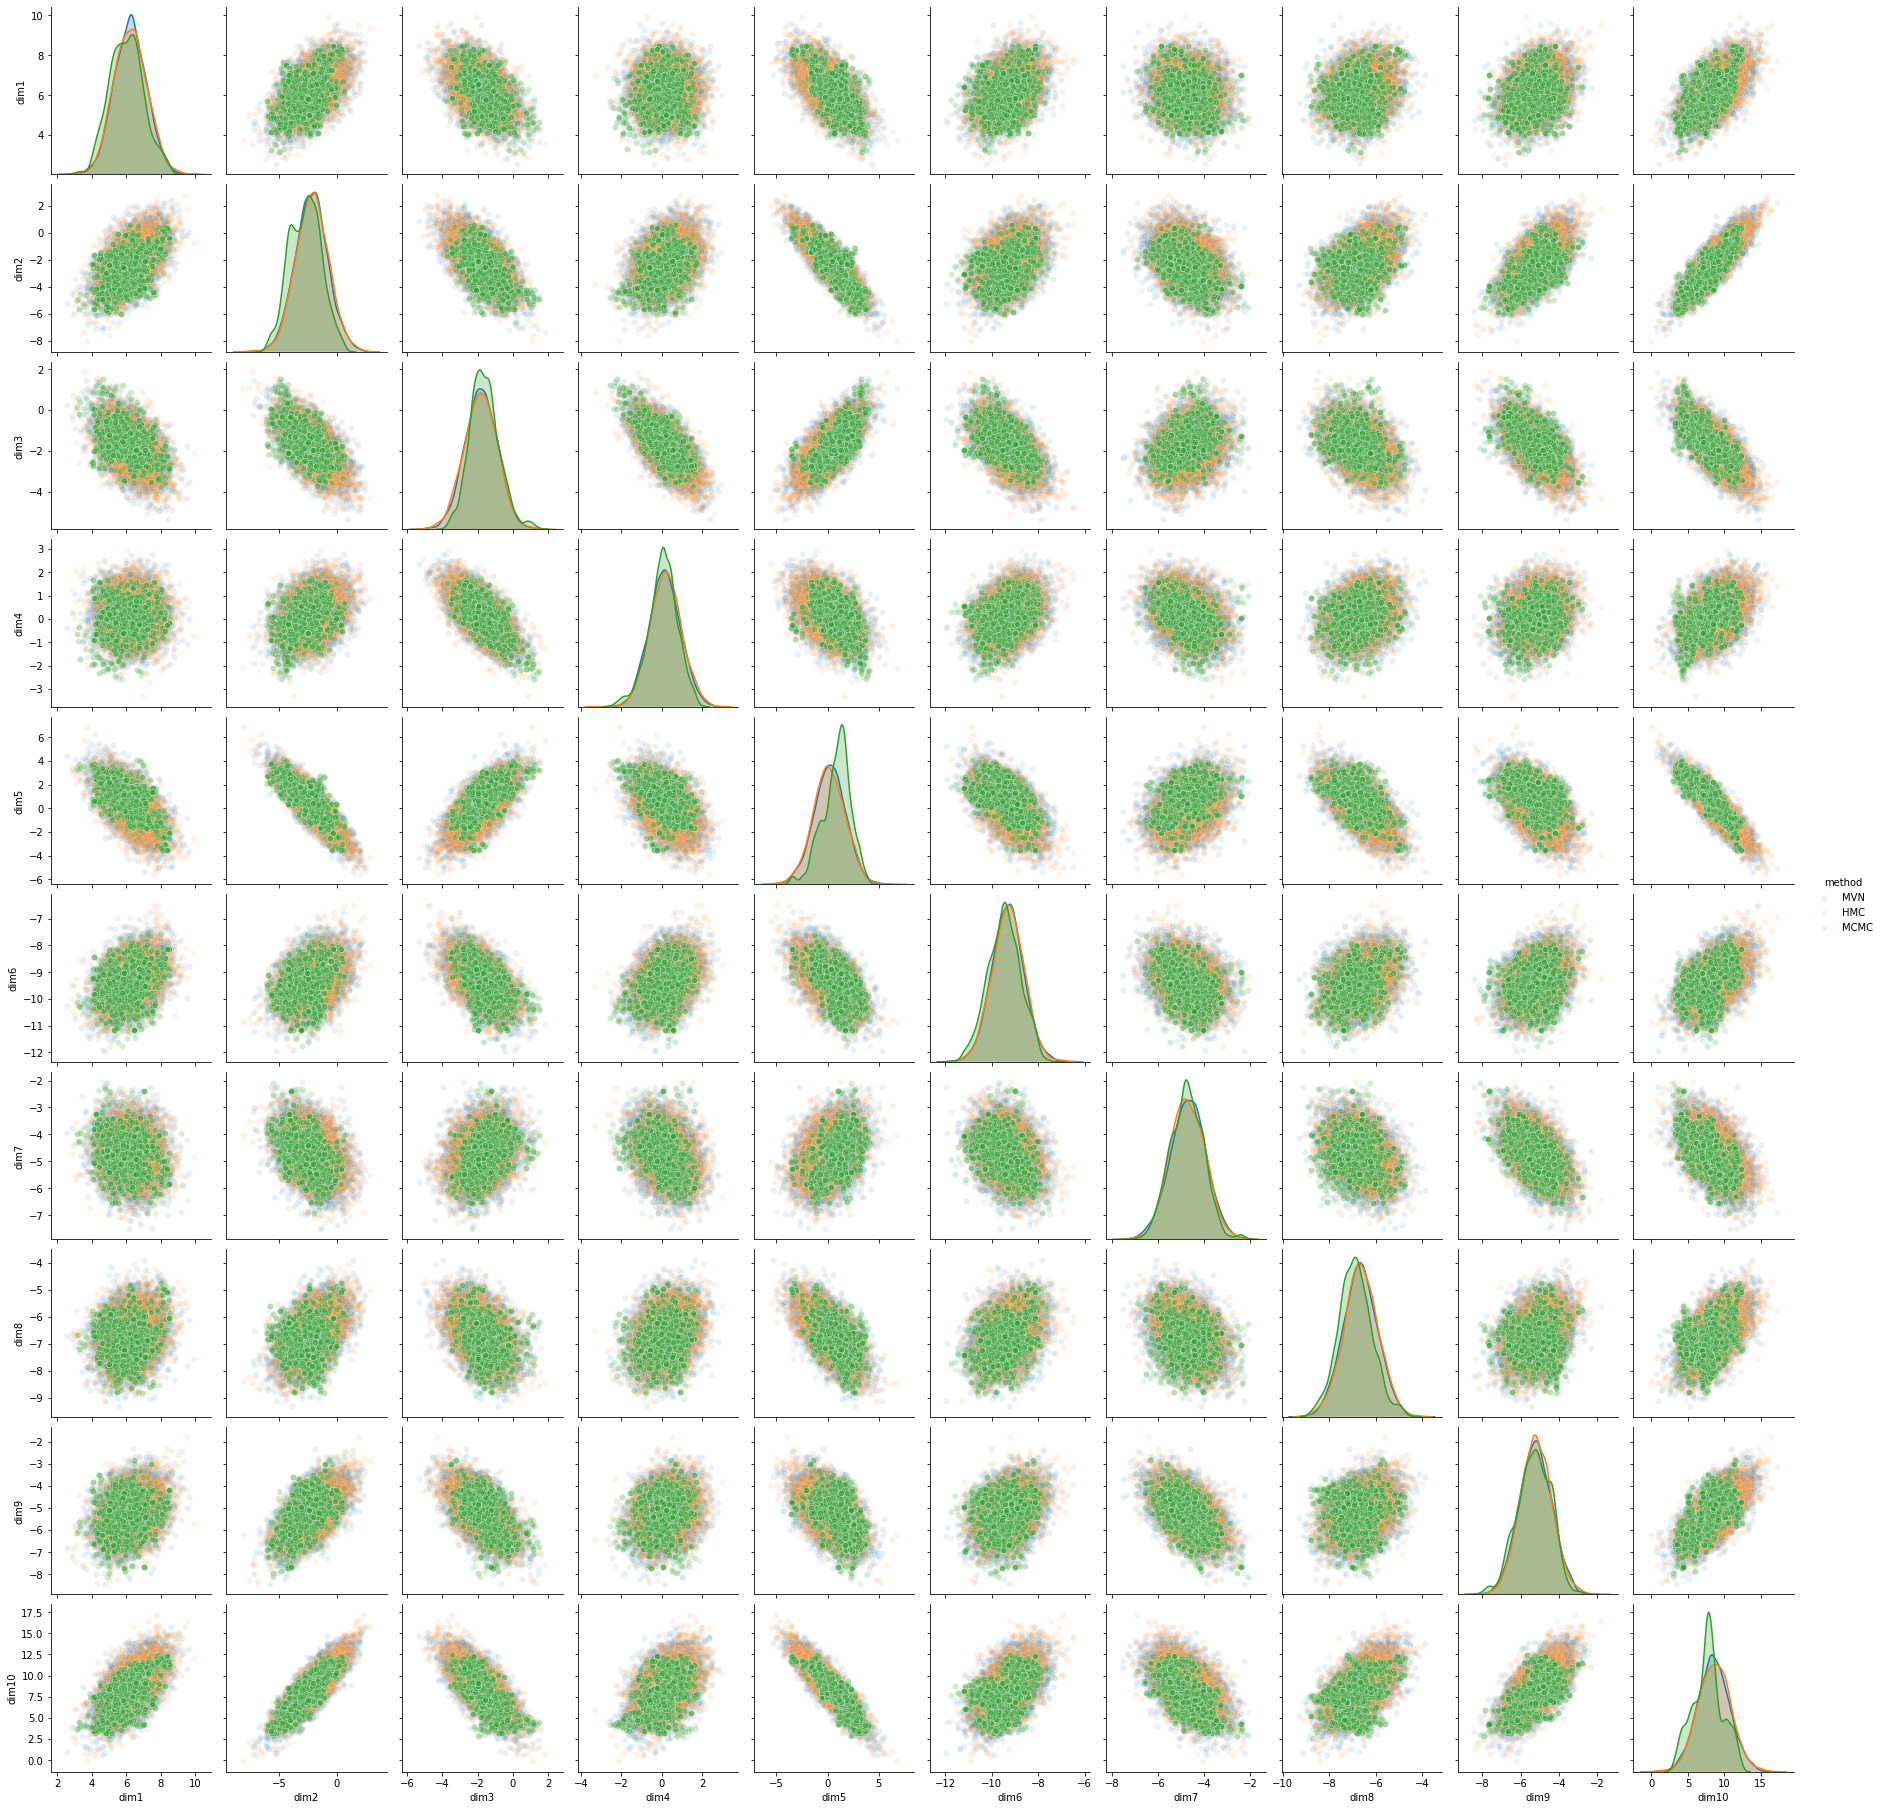

In [7]:
sns.pairplot(df, hue = 'method', plot_kws = {'alpha': 0.1})
plt.show();